# MLRC Langchain Walkthrough

# Introduction

Following on from an introduction to Langchain, we will be hosting a walkthrough into Langchain's ability to sequence task chains for question answering.

## Objective

We will be constructing an app that allows users to **retrive** pdf documents based on prompts and then further use those documents to perform **question answering** all within Langchain.

## Prerequisites



1.   OPENAI API Key
2.   Sample PDFs

*Please do not upload sensitive or confidential information*




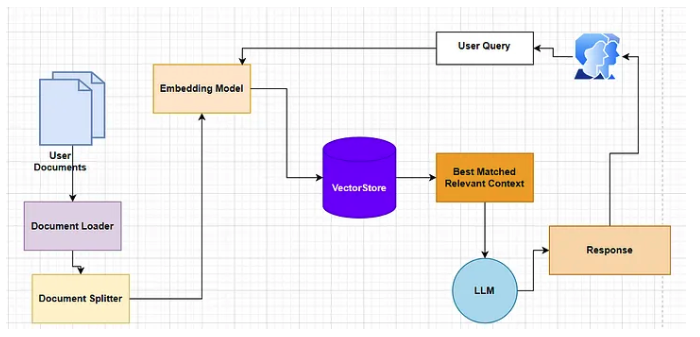

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install langchain_openai
!pip install langchain
!pip install langchain_community
!pip install PyPDF2
!pip install faiss-cpu
!pip install -q ragas==0.1.4
!pip install unstructured[pdf]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 1.7 MB/s eta 0:00:00


In [ ]:
import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_openai import OpenAI
from langchain.callbacks import get_openai_callback
import argparse
import pprint
import random
from tqdm import tqdm
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
import os
#from utils import *
#from langchain_openai import OpenAIEmbeddings
from langchain.chains.question_answering import load_qa_chain
from PyPDF2 import PdfReader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
#from langchain.vectorstores import ElasticVectorSearch, Pinecone, Weaviate
from langchain.schema import Document
from datetime import datetime
import re

In [ ]:
embeddings = OpenAIEmbeddings() # "text-embedding-ada-002"
llm = OpenAI(model_name="text-davinci-003", temperature=0.2) #This is the generative model we are using. We can switch this out with an argparser agument
# "text-embedding-ada-002" e.g.


### What is temperature?

A higher temperature value typically makes the output more diverse and creative but might also increase its likelihood of straying from the context. Conversely, a lower temperature value makes the AI's responses more focused and deterministic, sticking closely to the most likely prediction.

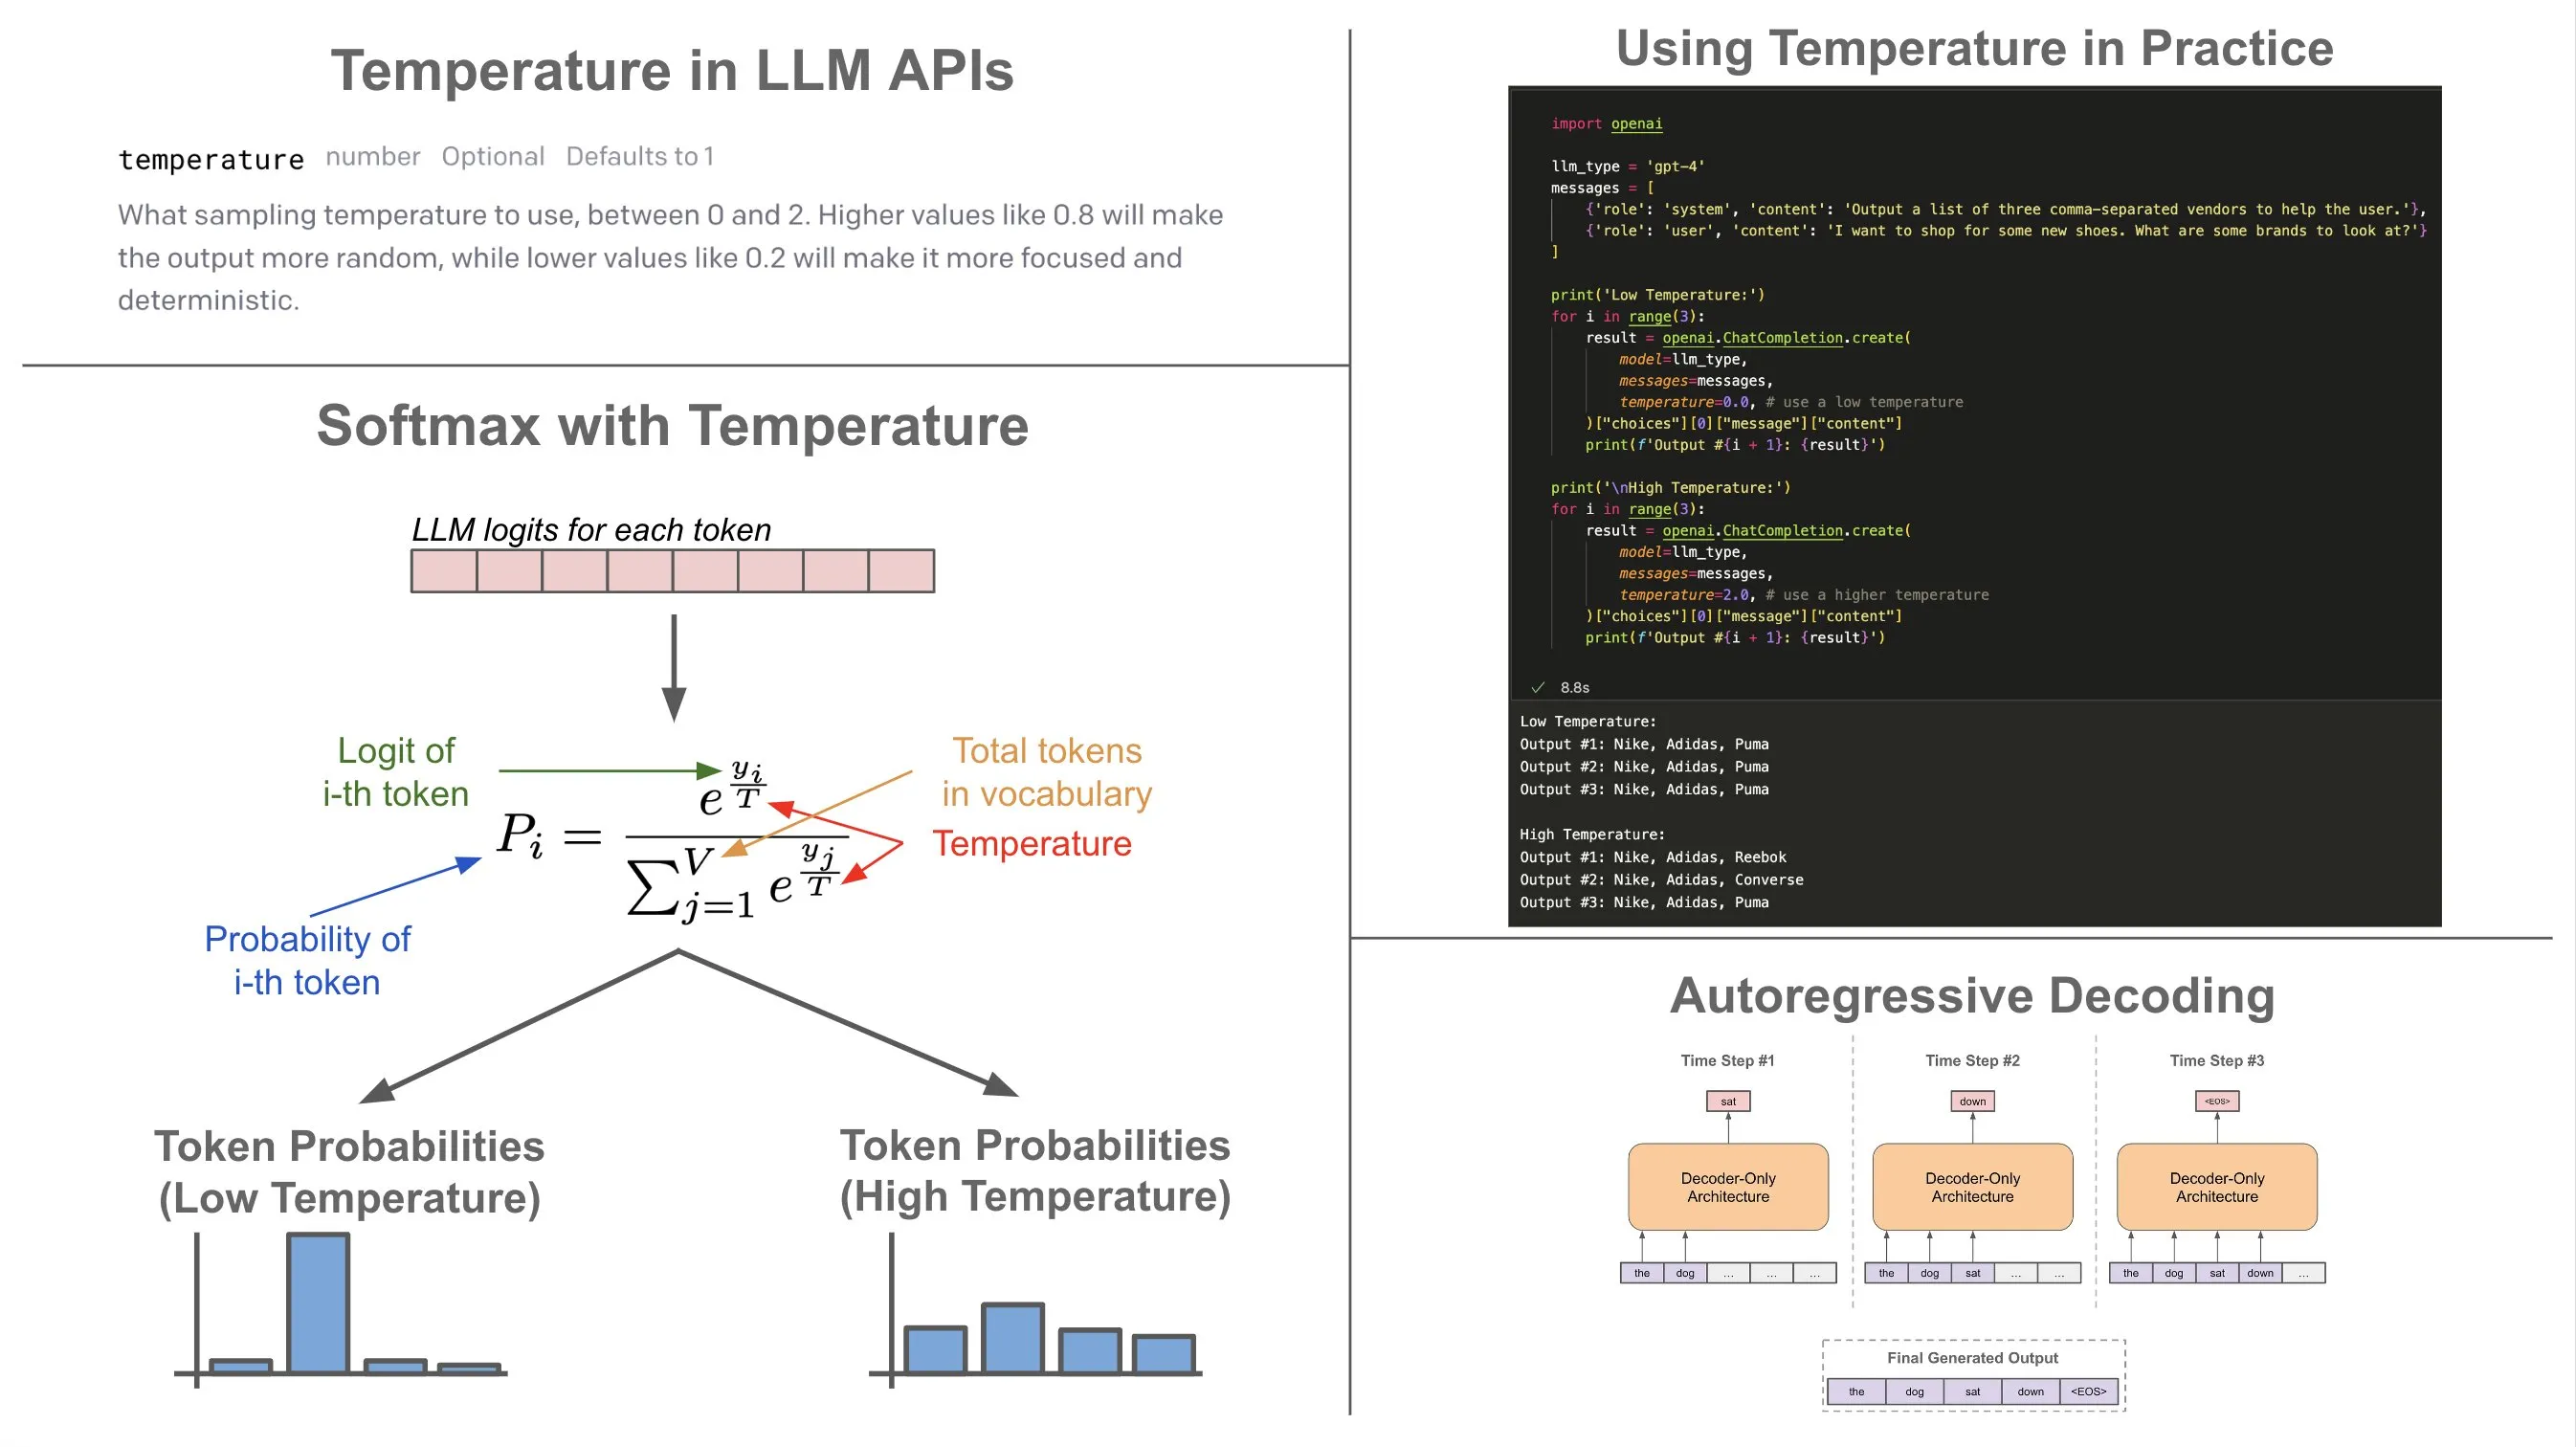

Source: https://medium.com/@amansinghalml_33304/temperature-llms-b41d75870510

In case we were behind a private instance, this is what a sample code would look like

```
pip install httpx

import httpx

openai = OpenAI(model_name="gpt-3.5-turbo-instruct", http_client=httpx.Client(proxies="http://proxy.yourcompany.com:8080"))
```



In [ ]:
directory_path = "sample_docs/"

# Utilities

In [ ]:
def list_pdf_files(directory):
    '''
    Takes a directory and returns the list of pdfs in it
    :param directory: directory path for files you want to search
    :return: returns a list of all files names that are pdfs
    '''
    pdf_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".pdf"):
                pdf_files.append(os.path.join(root, file))

    return pdf_files



How does an LLM "read documents"? Tokens!
Tokens are created from "chunks" of the document. Simplest framework would be each word is a token but this is not the best for memory or semantic performance. The retrieval greatly depends on how the chunks are manifested and stored in the vectorstore. Finding the right chunk size for any given text is a very hard question in general.

Improving Retrieval can be done by various retrieval method. But it can also be done by better chunking strategy.

Different chunking methods:

* Fixed size chunking
* Recursive Chunking - this is the one we will be using!
* Document Specific Chunking
* Semantic Chunking
* Agentic Chunking

Recursive Chunking : Recursive chunking divides the input text into smaller chunks in a hierarchical and iterative manner using a set of separators. If the initial attempt at splitting the text doesn’t produce chunks of the desired size or structure, the method recursively calls itself on the resulting chunks with a different separator or criterion until the desired chunk size or structure is achieved. This means that while the chunks aren’t going to be exactly the same size, they’ll still “aspire” to be of a similar size. Leverages what is good about fixed size chunk and overlap.

In [ ]:
def process_documents(pdf_files_list):
    '''
    This function uses the CharacterTextSplitter to make documents into smaller chunks admissible into LLMs

    :param pdf_files_list: this is the list of files from the directory
    :return: returns a doc list of processed documents
    '''
    docs = []
    for i, file in enumerate(pdf_files_list):
        reader = PdfReader(file)

        raw_text = ''
        for i, page in enumerate(reader.pages):
            text = page.extract_text()
            if text:
                raw_text += text
        #text_splitter = CharacterTextSplitter(separator='\n', chunk_size=1000, chunk_overlap=200, length_function=len)
        text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1250, chunk_overlap = 100, length_function = len, is_separator_regex = False)
        texts = text_splitter.split_text(raw_text)
        docs.append(Document(page_content="".join(texts), metadata=metadata_generator(file)))

    return docs


In [ ]:
def metadata_generator(pdf_file):
    '''
    This generates metadata for documents stored in a Vectordb
    :param pdf_file pdf_file name
    :return: returns a dictionary of the metadata
    '''
    temp = {"date_created": datetime.fromtimestamp(os.stat(pdf_file).st_ctime).strftime('%Y-%m-%d %H:%M:%S'),
            "file_name": re.search(r"/([^/]+)\.pdf$", pdf_file).group(1),
           "date_modified":datetime.fromtimestamp(os.stat(pdf_file).st_mtime).strftime('%Y-%m-%d %H:%M:%S')}
    return temp


In [ ]:
def pretty_print_docs(docs):
  print(
      f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n + {d.page_content[:1000]}" for i,d in enumerate(docs)])
  )

# Process files

In [ ]:
pdf_files_list = list_pdf_files(directory_path)
print('-----------------------------------')
print('These are the files in this folder:')
print('-----------------------------------')
for pdf_file in pdf_files_list:
    print(pdf_file)
print('-----------------------------------')


-----------------------------------
These are the files in this folder:
-----------------------------------
sample_docs/HW1 2.pdf
sample_docs/Simran_Masand_RES.pdf
sample_docs/QuantitativeMethods_CFA.pdf
sample_docs/invoice.pdf
sample_docs/invoice2.pdf
sample_docs/CS263 Project Proposal.pdf
sample_docs/706085004_MASAND.SIMRAN.RAJESH_G1_20230423061053.pdf
-----------------------------------


### We will now take our pdf files and convert them into embeddings and use a vectordb to store them. This allows easier retrieval in semantic search.

In [ ]:
docsall = process_documents(pdf_files_list) #process documents into a Document schema
vector_store=FAISS.from_documents(docsall,embeddings) #using openai schema, we process documents into vector database
retriever = vector_store.as_retriever(search_kwargs={"k": 1}) #get top k docs # this can be an argaparser requirement


Now we zero in on the document we want for QA purpose. You can set the k above to retrieve as many documents as possible. For simplicity, we are bringing back `k=1`

### A design question

These are some important design choices. If you want to work with a larger corpus of top-k documents, something to think about would be duplicate files and diversity.
You would want to perform a second run at your top-k choices to optimize Maximum Marginal Relevance(MMR).

MMR is an important method to enforce diversity in the search results. In the case of semantic search, we get documents that are most similar to the query in the embedding space and we may miss out on diverse information. The idea behind MMR is we first query the vector store and choose the “fetch_k” most similar responses. Now, we work on this smaller set of “fetch_k” documents and optimize to achieve both relevance to the query and diversity among the results. Finally, we choose the “k” most diverse response within these “fetch_k” responses.

### In practice

In [ ]:
query = input("What file are you looking for? For example: you can ask get me the invoice for flower bulbs. put another prompt here. Just press enter for a random prompt \n >> ")
if not query:
    query = random.choice(["get me the invoice for garden gnomes","get me Simran's CV"])
    print("\nWe chose the prompt: ", query)


What file are you looking for? For example: you can ask get me the invoice for flower bulbs. put another prompt here. Just press enter for a random prompt 
 >> Get me the projec tproposal


In [ ]:
docs = retriever.get_relevant_documents(query)

pp = pprint.PrettyPrinter()
print('-----------------------------------')
pp.pprint("Here is a peek at the document (first 1000 characters).")
print('-----------------------------------')

#pp.pprint("".join(docs[0].page_content[:1000].replace("\n"," ")))

pretty_print_docs(docs)

-----------------------------------
'Here is a peek at the document (first 1000 characters).'
-----------------------------------
Document 1:

 + C S 2 6 3 :
N L P
F i n a l
P r o j e c t
P r o p o s a l
T e a m
M e m b e r s
●
S i m r a n
M a s a n d
7 0 6 0 8 5 0 0 4
●
S h r u t h i
S r i n a r a s i
7 0 5 9 0 0 5 1 5
●
V a s u
E r a n k i
7 0 6 0 7 2 9 3 5
●
C h i n m a y
G u r j a r p a d h y e
5 0 5 8 5 2 1 0 5
F l i c k r
I m a g e
D a t a s e t :
I m a g e
t o
P r o m p t s
Our
task
for
this
challenge
is
to
predict
the
captions
that
were
annotated
on
the
images.
W e
expect
to
leverage
existing
visual
transformer
models
and
fine-tune
models
used
for
image
captioning.W e
will
choose
one
of
the
more
popular
benchmarks
e.g.
Nocaps
and
COCO;
BLEU
or
CIDER
metric.
W e
have
access
to
30,000
images
which
are
256x256.
https://www .kaggle.com/datasets/hsankesara/flickr-image-dataset
L i s t
o f
D e l i v e r a b l e s :
●
Literature
Survey
of
existing
models
●
Comparative
study
for
baseli

In [ ]:
chain = load_qa_chain(OpenAI(),chain_type='stuff')

In [ ]:
docs_focus = vector_store.similarity_search(query) #we can use the entire docs base but I am focussing the QA on the document in question


In [ ]:
with get_openai_callback() as cost:
    response = chain.run(input_documents=docs, question=query)
    print(cost)

Tokens Used: 925
	Prompt Tokens: 814
	Completion Tokens: 111
Successful Requests: 1
Total Cost (USD): $0.0014429999999999998


In [ ]:
query = None
end = "END"
while query != end:
    query = input("Ask your questions here. If you are done, just type END. \n > ")
    if query == "END":
        break
    if not query:
        query="Why is Simran amazing?"
    docs_focus = vector_store.similarity_search(query) #we can use the entire docs base but I am focussing the QA on the document in question
    print(chain.run(input_documents = docs,question=query))


Ask your questions here. If you are done, just type END. 
 > Tell me about this project
 This project is a final project proposal for a team working on predicting captions for images using existing transformer models and fine-tuning image captioning models. The team plans to choose a relevant dataset, conduct a literature review, implement various models, and evaluate their results. The deliverables for this project include a literature survey, comparative study, training and testing results, and an evaluation and conclusion. The project will be divided into different tasks, such as choosing and evaluating the dataset, image processing, literature review, model implementation, evaluation, and reporting and analysis. The team members are Simran Masand, Shruthi Srinarasi, Vasu Eranki, and Chinmay Gurjarpadhye. The project is expected to use 30,000 images that are 256x256 in size and will be based on popular benchmarks such as Nocaps and COCO with metrics such as BLEU or CIDER. 
Ask your 

# Advanced Section: Evaluating your Responses

In [ ]:
from langchain_community.document_loaders import DirectoryLoader
loader = DirectoryLoader("sample_docs")
documents = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
len(documents)

7

In [ ]:
import ragas
ragas.__version__

'0.1.10'

In [ ]:
import langchain
langchain.__version__

'0.2.6'

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4")


generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

# generate testset
testset = generator.generate_with_langchain_docs(documents, test_size=3, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 87, in run
    results = self.loop.run_until_complete(self._aresults())
  File "/usr/lib/python3.10/asyncio/base_events.py", line 625, in run_until_complete
    self._check_running()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 584, in _check_running
    raise RuntimeError('This event loop is already running')
RuntimeError: This event loop is already running
/usr/lib/python3.10/threading.py:1018: RuntimeWarning: coroutine 'Runner._aresults' was never awaited
  self._invoke_excepthook(self)
/usr/local/lib/python3.10/dist-packages/ragas/testset/docstore.py:252: RuntimeWarning: coroutine 'as_completed.<locals>.sema_coro' was never awaited
  results = executor.results()


ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.

In [ ]:

#
#load documents again to avoid any kind of bias
docsall_test = process_documents(pdf_files_list) #process documents into a Document schema

#
#
generator = TestsetGenerator.with_openai()
#
testset = generator.generate_with_langchain_docs(docsall_test, test_size=3, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

/usr/local/lib/python3.10/dist-packages/PyPDF2/generic/_data_structures.py:933: RuntimeWarning: coroutine 'Executor.wrap_callable_with_index.<locals>.wrapped_callable_async' was never awaited
  operands = []
<ipython-input-42-22ce05122b44>:9: DeprecationWarning: The function with_openai was deprecated in 0.1.4, and will be removed in the 0.2.0 release. Use from_langchain instead.
  generator = TestsetGenerator.with_openai()
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/ragas/executor.py", line 87, in run
    results = self.loop.run_until_complete(self._aresults())
  File "/usr/lib/python3.10/asyncio/base_events.py", line 625, in run_until_complete
    self._check_running()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 584, in _check_running
    raise RuntimeError('This event loop is already running')
RuntimeError: This 

ExceptionInRunner: The runner thread which was running the jobs raised an exeception. Read the traceback above to debug it. You can also pass `raise_exceptions=False` incase you want to show only a warning message instead.